# Course 4 Assignment 1

For this assignment we need to use a Classification Tree

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

import graphviz
from sklearn.tree import export_graphviz

In [2]:
# function to plot decisions trees
def plot_decision_tree(clf, feature_names, class_names):
    export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    with open("adspy_temp.dot") as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

## Loading and preparing data

In [3]:
# show all columns
pd.set_option('display.max_columns', None)
# loading the data from the local file
df = pd.read_csv('data/covid_data.csv')

In [4]:
# making the data more usable for a classifier, i will get the data for the last date and try and classify countries as high or low death rate
# prepare data
dfx = df.dropna(subset=['continent'])  # gets rid of summaries for 'world' and 'africa' etc, as I only want data for countries
dfx = dfx[dfx.date == '2021-04-28']
cols = ['location', 'total_cases_per_million', 'total_deaths_per_million', 'population', 'population_density', 'people_fully_vaccinated',
       'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 
        'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
dfx.people_fully_vaccinated = dfx.people_fully_vaccinated.fillna(0)  # if there is no data for vaccinations, I will assume it's 0
dfx = dfx[cols].dropna()
dfx['percentage_fully_vaccinated'] = (dfx.people_fully_vaccinated/dfx.population) * 100
# binning response variable
dfx['total_deaths_binned'] = pd.cut(dfx.total_deaths_per_million, 2, labels=['low', 'high'])
# dropping columns I have transformed so the data isn't there twice as that would affect predictions
dfx.drop(['people_fully_vaccinated', 'total_deaths_per_million'], axis=1, inplace=True)
dfx.tail(10)

,location,total_cases_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,percentage_fully_vaccinated,total_deaths_binned
80089,United Arab Emirates,52202.237,9890400.0,112.442,34.0,1.144,0.526,67293.483,317.840,17.26,1.20,77.97,0.890,0.000000,low
80544,United Kingdom,65218.009,67886004.0,272.898,40.8,18.517,12.527,39753.244,122.137,4.28,2.54,81.32,0.932,20.687565,high
81008,United States,97373.390,331002647.0,35.608,38.3,15.413,9.732,54225.446,151.089,10.79,2.77,78.86,0.926,29.620434,high
81421,Uruguay,55567.694,3473727.0,19.751,35.6,14.655,10.361,20551.409,160.708,6.93,2.80,77.91,0.817,17.007065,low
81832,Uzbekistan,2689.279,33469199.0,76.134,28.2,4.469,2.873,6253.104,724.417,7.57,4.00,71.72,0.720,0.000000,low
82835,Venezuela,6856.076,28435943.0,36.253,29.0,6.614,3.915,16745.022,204.850,6.47,0.80,72.06,0.711,0.000000,low
83298,Vietnam,29.433,97338583.0,308.127,32.6,7.150,4.718,6171.884,245.465,6.00,2.60,75.40,0.704,0.000000,low
84147,Yemen,209.985,29825968.0,53.508,20.3,2.922,1.583,1479.147,495.003,5.35,0.70,66.12,0.470,0.000000,low
84555,Zambia,4976.296,18383956.0,22.995,17.7,2.480,1.542,3689.251,234.499,3.94,2.00,63.89,0.584,0.000000,low
84961,Zimbabwe,2569.548,14862927.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,1.70,61.49,0.571,0.470917,low


## Decision Trees

In [5]:
y = dfx.total_deaths_binned
X = dfx.drop(['total_deaths_binned', 'location'], axis=1)  # decision trees don't like strings, so no locations
X

,total_cases_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,percentage_fully_vaccinated
429,1525.110,38928341.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.50,64.83,0.511,0.000000
1301,45471.888,2877800.0,104.871,38.0,13.188,8.643,11803.431,304.195,10.08,2.89,78.57,0.795,0.000000
1731,2772.568,43851043.0,17.348,29.1,6.211,3.857,13913.839,278.364,6.73,1.90,76.88,0.748,0.000000
3052,12580.672,97928.0,231.845,32.1,6.933,4.631,21490.943,191.511,13.17,3.80,77.02,0.778,0.000000
3537,64804.506,45195777.0,16.177,31.9,11.198,7.441,18933.907,191.032,5.50,5.00,76.67,0.845,1.958694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82835,6856.076,28435943.0,36.253,29.0,6.614,3.915,16745.022,204.850,6.47,0.80,72.06,0.711,0.000000
83298,29.433,97338583.0,308.127,32.6,7.150,4.718,6171.884,245.465,6.00,2.60,75.40,0.704,0.000000
84147,209.985,29825968.0,53.508,20.3,2.922,1.583,1479.147,495.003,5.35,0.70,66.12,0.470,0.000000
84555,4976.296,18383956.0,22.995,17.7,2.480,1.542,3689.251,234.499,3.94,2.00,63.89,0.584,0.000000


In [15]:
# split the data in to test and train sets
# random state means I will get the same results each time I run this
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.4, random_state=18)  

# fit the model
clf = DecisionTreeClassifier().fit(X_train, y_train)

# get predictions
y_hat = clf.predict(X_test)

sklearn.metrics.confusion_matrix(y_test, y_hat)

array([[10,  7],
       [ 5, 70]], dtype=int64)

In [16]:
sklearn.metrics.accuracy_score(y_test, y_hat)

0.8695652173913043

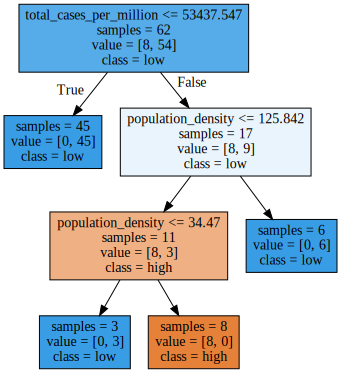

In [17]:
plot_decision_tree(clf, X.columns, ['high', 'low'])

## Summary

I used a number of variables in a classification tree to try and predict if a country would have high or low covid-19 related deaths per million.

Unsurprisingly, the first split in the decision tree was made on the total number of cases per million people a country had, with those having fewer than or equal 53437.547 cases per million immediately being classed as low deaths. Looking at the original data, this isn't exactly true, as Mexico is in that bracket and high deaths, but it's very close. The further splits on varying values for population density also make sense examining the data, those with very high and very low population densities are likely to have low total deaths, while those in the middle are likely to have high total deaths.

However, the variable I have been investigating, percentage of people fully vaccinated, did not show up in the tree. This doesn't mean it wouldn't if I ran it again with a different subset of test data.